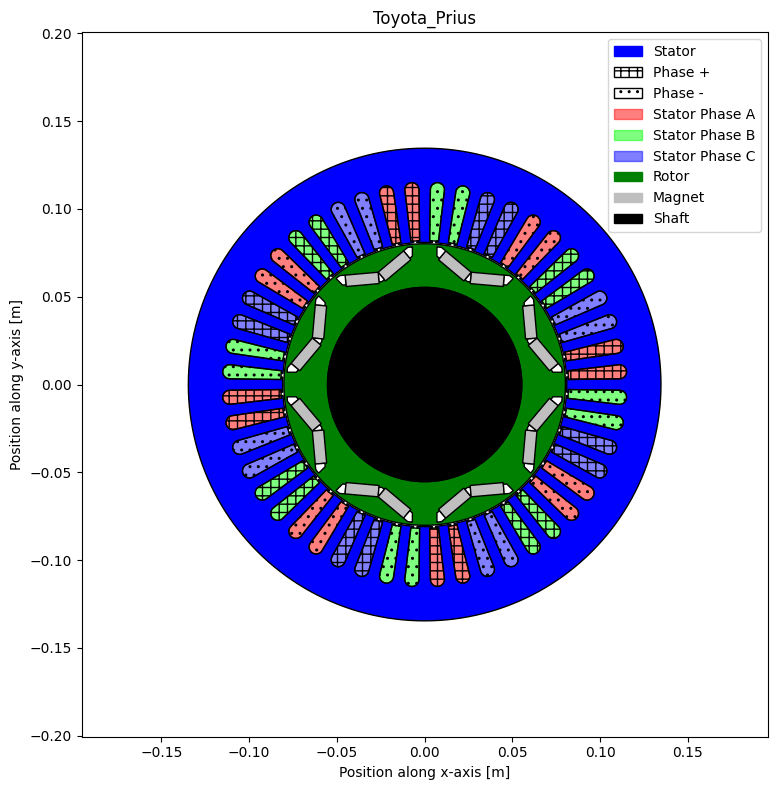

In [7]:
%matplotlib inline

# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
#from util.simulation import *
import itertools
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
import numpy as np
machine = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# In Jupyter notebook, we set is_show_fig=False to skip call to fig.show() to avoid a warning message
# All plot methods return the corresponding matplotlib figure and axis to further edit the resulting plot
fig, ax = machine.plot(is_show_fig=False)
plt.show()

In [8]:
# Affichage de l'ancien entrefer  du stator(Rint)
print("Ancien Rint du stator :", machine.stator.Rint)

Ancien Rint du stator : 0.08095


In [9]:
# Modification de Rint (-1.0 mm) Très petit
machine.stator.Rint -= 0.001

In [10]:
# Affichage  de nouveau entrefer
print("Nouveau Rint du stator :", machine.stator.Rint)

Nouveau Rint du stator : 0.07995


In [11]:
# Sauvegarde de la machine modifiée
machine.save("Toyota_Prius_Rint_-1.0mm.json")

[14:22:33] Saving MachineIPMSM to file 'Toyota_Prius_Rint_-1.0mm.json'.
Saving MachineIPMSM to file 'Toyota_Prius_Rint_-1.0mm.json'.


In [ ]:
----------------------------------------------------------------------------------------------------------------------------

---------------------------Simulation-----------------------------------------

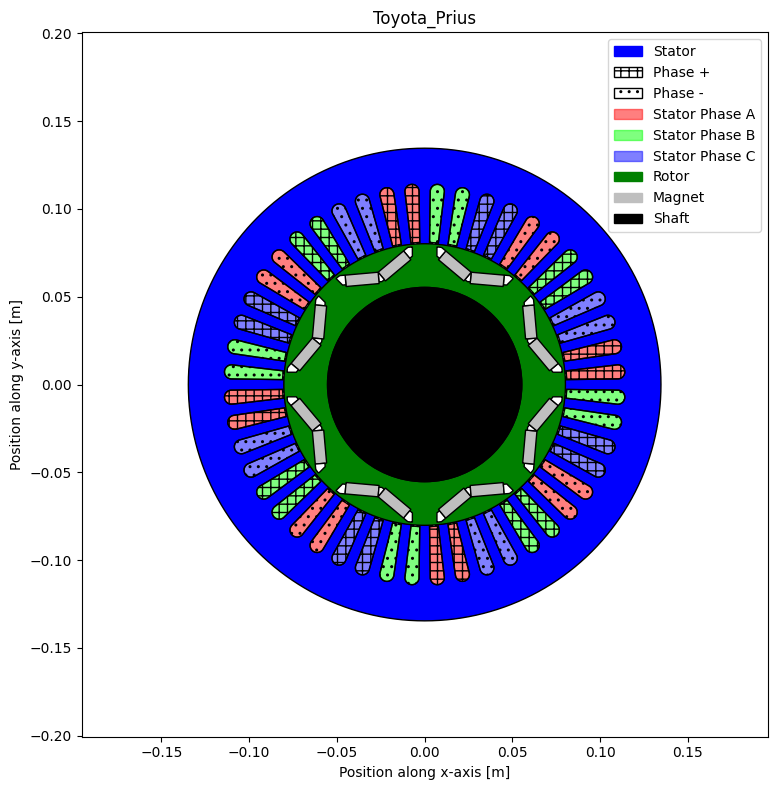

In [12]:
%matplotlib inline

# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

IPMSM_A = load("Toyota_Prius_Rint_-1.0mm.json")
# In Jupyter notebook, we set is_show_fig=False to skip call to fig.show() to avoid a warning message
# All plot methods return the corresponding matplotlib figure and axis to further edit the resulting plot
fig, ax = IPMSM_A.plot(is_show_fig=False)
plt.show()

In [13]:
from os.path import join

from numpy import ones, pi, array, linspace, cos, sqrt

from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM

# Create the Simulation
simu_femm = Simu1(name="FEMM_simulation", machine=IPMSM_A)   
# simu_femm.path_result = "path/to/folder" Path to the Result folder to use (will contain FEMM files)
p = simu_femm.machine.stator.winding.p
qs = simu_femm.machine.stator.winding.qs

# Defining Simulation Input
simu_femm.input = InputCurrent()

# Rotor speed [rpm]
N0 = 3000 
simu_femm.input.OP = OPdq(N0=N0)

# time discretization [s]
time = linspace(start=0, stop=60/N0, num=32*p, endpoint=False) # 32*p timesteps
simu_femm.input.time = time 

# Angular discretization along the airgap circonference for flux density calculation
simu_femm.input.angle = linspace(start = 0, stop = 2*pi, num=2048, endpoint=False) # 2048 steps 

# Stator currents as a function of time, each column correspond to one phase [A]
I0_rms = 250/sqrt(2) 
felec = p * N0 /60 # [Hz]
rot_dir = simu_femm.machine.stator.comp_mmf_dir()
Phi0 = 140*pi/180  # Maximum Torque Per Amp

Ia = (
    I0_rms
    * sqrt(2)
    * cos(2 * pi * felec * time + 0 * rot_dir * 2 * pi / qs + Phi0)
)
Ib = (
    I0_rms
    * sqrt(2)
    * cos(2 * pi * felec * time + 1 * rot_dir * 2 * pi / qs + Phi0)
)
Ic = (
    I0_rms
    * sqrt(2)
    * cos(2 * pi * felec * time + 2 * rot_dir * 2 * pi / qs + Phi0)
)
simu_femm.input.Is = array([Ia, Ib, Ic]).transpose()

In [14]:
from pyleecan.Classes.MagFEMM import MagFEMM

simu_femm.mag = MagFEMM(
    type_BH_stator=0, # 0 to use the material B(H) curve, 
                      # 1 to use linear B(H) curve according to mur_lin,
                      # 2 to enforce infinite permeability (mur_lin =100000)
    type_BH_rotor=0,  # 0 to use the material B(H) curve, 
                      # 1 to use linear B(H) curve according to mur_lin,
                      # 2 to enforce infinite permeability (mur_lin =100000)
    file_name = "", # Name of the file to save the FEMM model
    is_fast_draw=True,  # Speed-up drawing of the machine by using lamination periodicity
    is_sliding_band=True,  # True to use the symetry of the lamination to draw the machine faster
    is_calc_torque_energy=True, # True to calculate torque from integration of energy derivate over rotor elements
    T_mag=60,  # Permanent magnet temperature to adapt magnet remanent flux density [°C]
    is_remove_ventS=False,  # True to remove stator ventilation duct
    is_remove_ventR=False,  # True to remove rotor ventilation duct
)

# Only the magnetic module is defined
simu_femm.elec = None
simu_femm.force = None
simu_femm.struct = None 

In [15]:
simu_femm.mag.is_periodicity_a=True

In [16]:
simu_femm.mag.is_periodicity_t=True

In [17]:
simu_femm.mag.nb_worker = 4  # Number of FEMM instances to run at the same time (1 by default)

In [18]:
simu_femm.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
simu_femm.mag.is_save_meshsolution_as_file = False # To save FEA results in a dat file

In [19]:
out_femm = simu_femm.run()

[14:23:24] Starting running simulation FEMM_simulation (machine=Toyota_Prius)
[14:23:24] Starting Magnetic module
[14:23:25] Computing Airgap Flux in FEMM


Exception: error: An (anti)periodic BC is assigned to more than two segments

en réduisant Rint de -1.0 mm, le rotor et le stator deviennent trop proches, voire se chevauchent. 
FEMM n'arrive plus à placer correctement les conditions aux limites périodiques dans l'entrefer.

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Toyota_Prius'}, xlabel='Position along x-axis [m]', ylabel='Position along y-axis [m]'>)

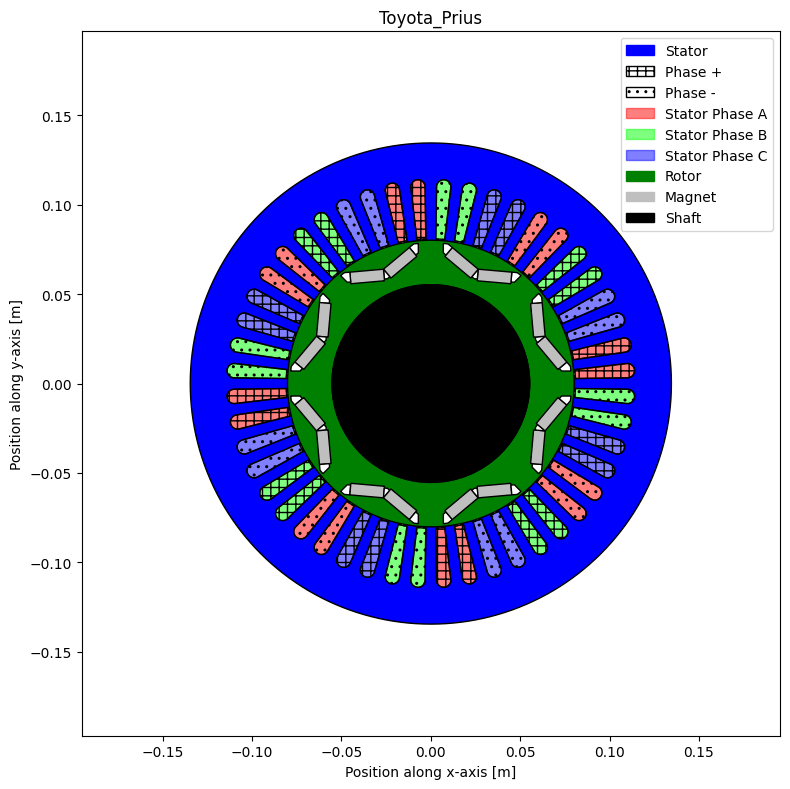

In [21]:
machine.plot() # verification de la geometrie


--------------------------------------------------------------------------------------------------------------------------------------------------------------